In [32]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)#Thresholding using Otsu's threshold and Binary Inverse threshold
kernel = np.ones((3,3),dtype='uint8')
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)#Closing any holes using Morphilogical closing.
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)#Outputs a list of all contours in the image as the first output. Each contour is an array of (x,y) coordinate of the boundry.

In [34]:
delta_x=15#maximum ossible distance between the same nut in 2 frames

In [35]:
def get_indexed_image(im):
    th, im_th = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = np.ones((3,3),dtype='uint8')
    closing_im = cv.morphologyEx( im_th, cv.MORPH_CLOSE, kernel)
    retval, labels, stats, centroids= cv.connectedComponentsWithStats(closing_im)
    return (retval, labels, stats, centroids)

In [36]:
 #is_new function checks whether a nut in a frame is new or not compared to the previouse frame.
def is_new(a, b, delta, i):
    abs_dif=np.abs(a[:,i]-b[i])
    if (np.all(abs_dif>delta,axis=0)==False):
        return False
    else:
        return True 

In [37]:
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
is_new(a, b, delta, i)

False

In [38]:
#If the nut is not new according to above function then nut's index in previous frame is calculated using prev_index function.
def prev_index(a, b, delta, i):
        index = -1
        k=np.abs(a-b)
        k=k[:,i]
        truth=np.all(k<=delta,axis=1)
        for j in range(len(truth)):
            if truth[j]==True:
                index=j
        return index


In [39]:
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
prev_index(a, b, delta, i)

1

In [40]:
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
Video_cap_gray=[]
Video_cap_color=[]
Conts=[]
All_prev_frame=[]
Contours=[]
c=0
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray= cv.cvtColor(frame, cv.COLOR_BGR2GRAY)# turn the frame into grayscale 
    retval, labels, stats, centroids=get_indexed_image(gray)#get label distribution of the frame 
    l=1
    im=((labels>=l)*255).astype('uint8')  
    contours, hierarchy = cv.findContours(im,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)#get contours of the frame 
    im_contours_belt = np.zeros((gray.shape[0],gray.shape[1],3), np.uint8)
    conts= cv.drawContours(im_contours_belt,contours, -1, (0,255,0), 3).astype('uint8')#draw the contours on a black background 
    Prev_frame=[]
    count=0
    for cnt in contours:#consider each contour in contours.
        match=cv.matchShapes(contours_t[0], cnt, cv.CONTOURS_MATCH_I1, 0.0)#calculate how much hexagen nut's outer contour matches with each contour. 
        if match<0.5:# if matching value is below 0.5 complete hexagen nut is present. By this condition we can filter out incomplete hexagen nuts in a frame. 
            M  = cv.moments(cnt)
            ca =  cv.contourArea(cnt)
            cx, cy = int(M['m10']/M['m00']),int(M['m01']/M['m00'])
            count+=1
            prev_frame=np.array([cx,cy,ca,count])
            Prev_frame.append(prev_frame)
    
    c+=1 
    Prev_frame=np.asarray(Prev_frame)
    All_prev_frame.append(Prev_frame)
    Conts.append(conts)
    Contours.append(contours)
    Video_cap_color.append(frame)
    Video_cap_gray.append(gray)
    

Can't receive frame (stream end?). Exiting ...


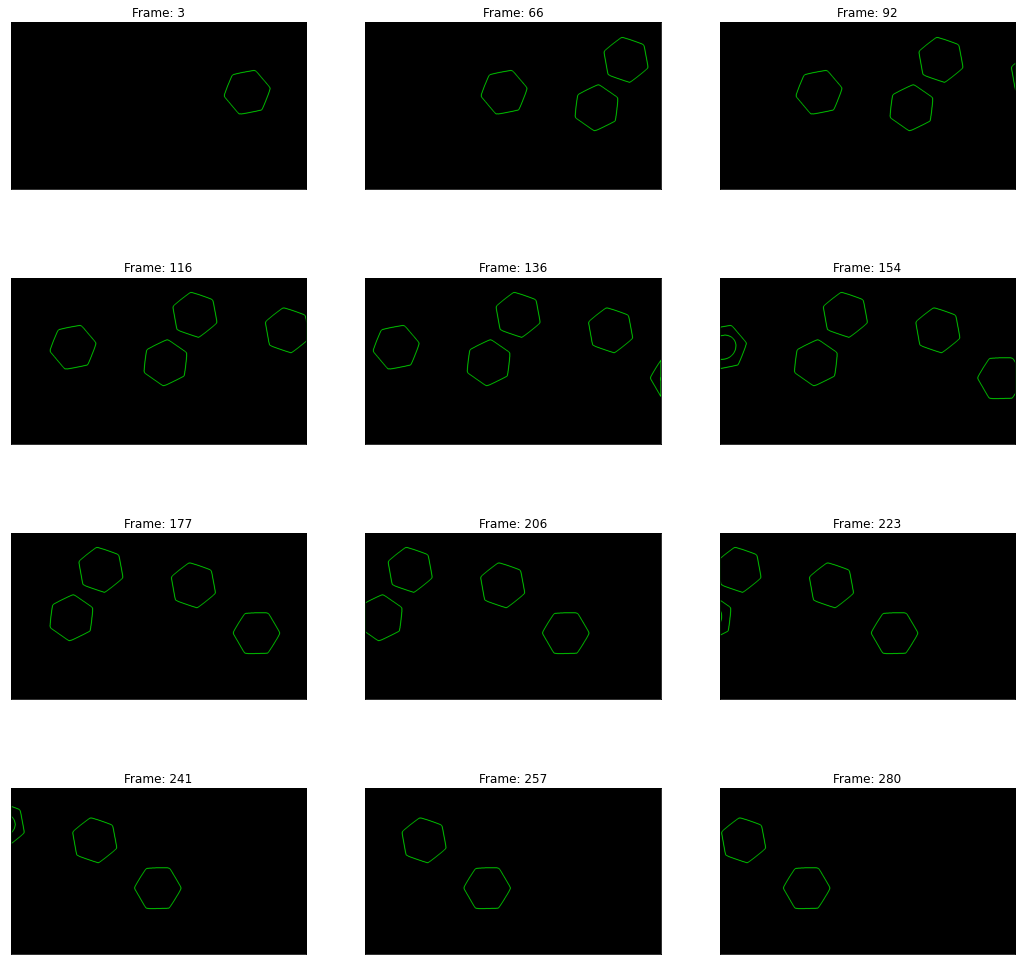

In [41]:
#Plot some randomly chosen drawn contours from above
I=[2,65,91,115,135,153,176,205,222,240,256,279]#randomly chosen frames 
fig, ax = plt. subplots(4,3,figsize=(18,18)) 
for i in range(12):
    plt.subplot(4,3,i+1),plt.imshow(Conts[I[i]],'gray')
    plt.title("Frame: "+str(I[i]+1))
    plt.xticks([]),plt.yticks([])
plt.show()

In [42]:
#Using above mentioned is_new and prev_index functions track the hexagen nuts and indice them.
delta = np.array([delta_x])
i = np.array([0])
t_nuts=All_prev_frame[0][-1][3]#since 1st frame don't have any previous frames we get the number of complete nuts in frame 1 as initial number of nuts
for k in range(1,len(All_prev_frame)):
    for j in All_prev_frame[k]:
          if (is_new(All_prev_frame[k-1],j,delta,i))==False:
            index_in_prev_frame=prev_index(All_prev_frame[k-1],j,delta, i)# if the nut is not new find its index on previous frame
            j[3]  = All_prev_frame[k-1][index_in_prev_frame][3]# assigning that previous frame's index as object's current frame's count

          else:
            t_nuts +=1
            j[3] = t_nuts #if the nut is new update the total number of nuts by 1 and assign it as object's current frames count
            

In [43]:
#Drawing contours and adding relavent information to each frame as text
Final_img=[]
for i in range(len(Video_cap_color)):
    final_img = cv.putText(Video_cap_color[i], "Frame: "+str(i) , (75,750) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,255), 3)
    final_img= cv.drawContours(Video_cap_color[i],Contours[i], -1, (255,0,255), 3).astype('uint8')
    y=0
    for k in All_prev_frame[i]:
        s=int(k[3])
        final_img = cv.putText(Video_cap_color[i],str(s), (int(k[0]),int(k[1])) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,255), 3)
        final_img = cv.putText(Video_cap_color[i], "Object "+str(int(k[3]))+": "+str(int(k[0]))+"  "+str(int(k[1]))+"  "+str(int(k[2])),(75,850 +65*y), cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,255), 4)
        y+=1
    Final_img.append(final_img)

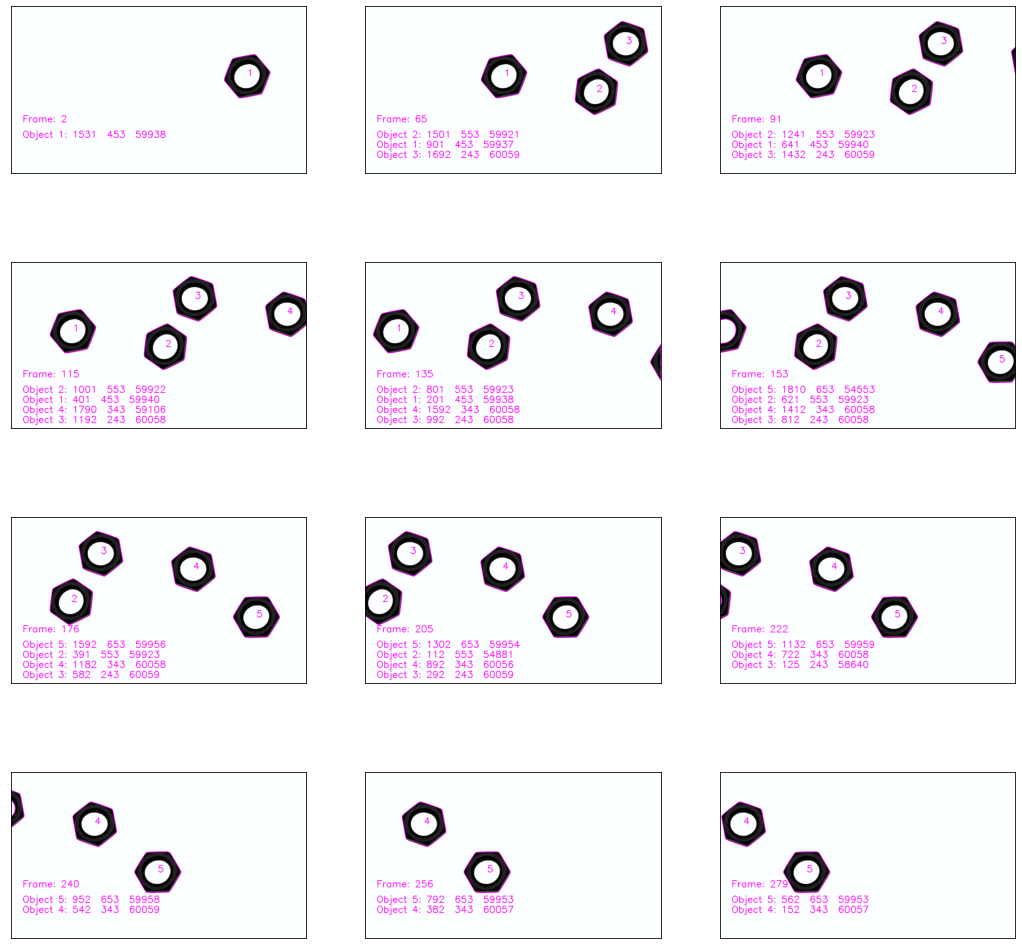

In [44]:
#Plot some randomly chosen contour and text added frames.
fig, ax = plt. subplots(4,3,figsize=(18,18)) 
for i in range(12):
    plt.subplot(4,3,i+1),plt.imshow(Final_img[I[i]],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

In [45]:
#Write the final edited frames into a viedo
fourcc = cv.VideoWriter_fourcc(*'MP4V') 
frame_rate = int(len(Final_img)/9) 
out = cv.VideoWriter('Output video.mp4' , fourcc, frame_rate,(Final_img[0].shape[1],Final_img[0].shape[0]), True)
for frame in Final_img:
    out.write(frame)
out.release()